In [51]:
import logging
from datetime import datetime

# Create and configure logger
log_file = "vit_training.log"
logging.basicConfig(
    filename=log_file,
    filemode='a',
    format='%(asctime)s - %(levelname)s - %(message)s',
    level=logging.INFO
)

# Initial log
logging.info("==== Starting Vision Transformer Project ====")


In [52]:
logging.info("Moved to Google Colab for GPU support. Environment initialized.")


In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import logging
from datetime import datetime


In [54]:

# Log the step
logging.info("Setting up CIFAR-10 dataset and DataLoaders with standard normalization.")

# Define transforms
cifar10_mean = [0.4914, 0.4822, 0.4465]
cifar10_std = [0.2471, 0.2435, 0.2616]

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar10_mean, std=cifar10_std)
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar10_mean, std=cifar10_std)
])

# Download and load the CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

# Log success
logging.info(f"Loaded CIFAR-10 dataset: {len(train_dataset)} training images, {len(val_dataset)} validation images.")


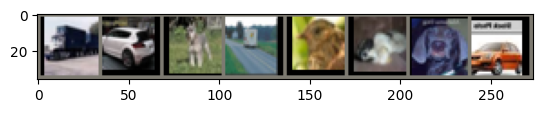

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Helper to unnormalize
def imshow(img):
    img = img * torch.tensor(cifar10_std).view(3,1,1) + torch.tensor(cifar10_mean).view(3,1,1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get one batch
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:8]))


In [56]:
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=128):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2

        # Linear projection of flattened patches
        self.proj = nn.Linear(patch_size * patch_size * in_channels, embed_dim)

        # [CLS] token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # Positional embeddings for [CLS] + all patches
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))

    def forward(self, x):
        B, C, H, W = x.shape  # batch, channels, height, width

        # Step 1: Split into patches
        x = x.unfold(2, self.patch_size, self.patch_size)
        x = x.unfold(3, self.patch_size, self.patch_size)
        x = x.contiguous().view(B, C, -1, self.patch_size, self.patch_size)
        x = x.permute(0, 2, 1, 3, 4).contiguous()
        x = x.view(B, self.num_patches, -1)

        # Step 2: Project to embed_dim
        x = self.proj(x)

        # Step 3: Add [CLS] token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # Step 4: Add positional embeddings
        x = x + self.pos_embed

        return x


In [57]:
patch_embed = PatchEmbedding()
dummy_input = torch.randn(8, 3, 32, 32)

output = patch_embed(dummy_input)

print("Patch Embed output shape:", output.shape)


Patch Embed output shape: torch.Size([8, 65, 128])


In [58]:
logging.info("Implemented PatchEmbedding module with CLS token and positional embeddings.")


In [59]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim=128, num_heads=4, mlp_dim=512, dropout=0.1):
        super(TransformerEncoderBlock, self).__init__()

        # Multi-head self-attention
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout)

        # MLP block (Feedforward network)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # Attention block
        attn_output, _ = self.attn(x, x, x)
        x = self.norm1(x + self.dropout1(attn_output))

        # MLP block
        mlp_output = self.mlp(x)
        x = self.norm2(x + mlp_output)

        return x


In [60]:
encoder_block = TransformerEncoderBlock()
dummy_input = torch.randn(8, 65, 128)  # [B, num_patches + 1, embed_dim]
out = encoder_block(dummy_input)
print("Transformer block output shape:", out.shape)


Transformer block output shape: torch.Size([8, 65, 128])


In [61]:
logging.info("Implemented single TransformerEncoderBlock with multi-head attention and MLP.")


In [62]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=128,
                 num_transformer_blocks=6, num_heads=4, mlp_dim=512, num_classes=10,
                 dropout=0.1):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.transformer_blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_dim, dropout)
            for _ in range(num_transformer_blocks)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)

        for block in self.transformer_blocks:
            x = block(x)

        # Take the [CLS] token output
        cls_token_output = x[:, 0]

        x = self.norm(cls_token_output)
        x = self.fc(x)
        return x

In [63]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)

# Learning rate scheduler with cosine annealing
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

logging.info("Set up AdamW optimizer and cosine annealing LR scheduler.")


In [64]:
from tqdm import tqdm

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


def validate(model, loader, criterion, device):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    return val_loss / total, correct / total


In [65]:
epoch_options = [10, 20, 30]
all_train_losses = []
all_val_losses = []
all_train_accs = []
all_val_accs = []


In [66]:
for max_epochs in epoch_options:
    logging.info(f"Starting training for {max_epochs} epochs.")

    model = VisionTransformer().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_acc = 0

    for epoch in range(max_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        scheduler.step()

        # Logging and checkpoint
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"checkpoints/best_vit_{max_epochs}ep.pth")
            logging.info(f"[{max_epochs} epochs] Epoch {epoch}: New best val_acc={val_acc:.4f}")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

    # Save metrics for plotting later
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accs.append(train_accs)
    all_val_accs.append(val_accs)

    logging.info(f"Finished training for {max_epochs} epochs.")


Training: 100%|██████████| 782/782 [00:31<00:00, 25.00it/s]


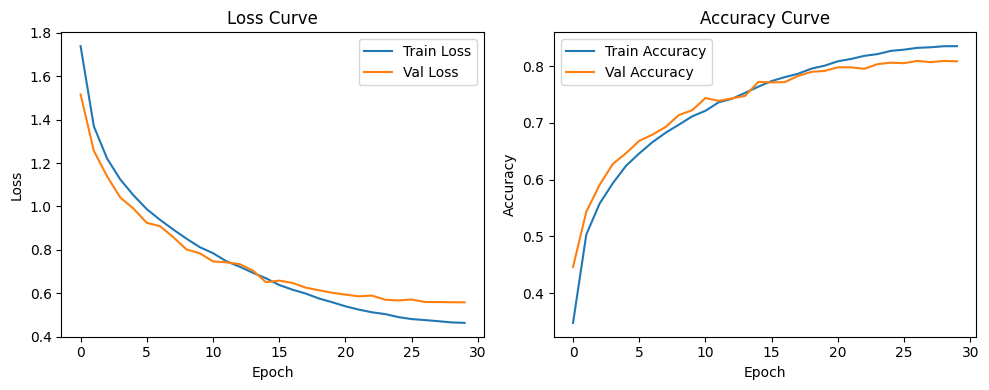

In [67]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

logging.info("Plotted training and validation loss/accuracy curves.")


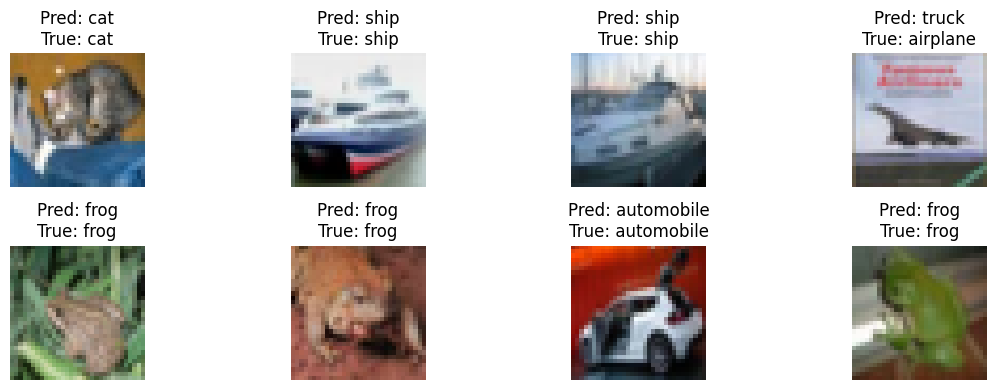

In [68]:
classes = train_dataset.classes

def show_predictions(model, loader, device, num_images=8):
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            plt.figure(figsize=(12, 4))
            for i in range(num_images):
                img = images[i].cpu()
                img = img * torch.tensor(cifar10_std).view(3, 1, 1) + torch.tensor(cifar10_mean).view(3, 1, 1)
                img = img.permute(1, 2, 0).numpy()

                plt.subplot(2, 4, i+1)
                plt.imshow(img)
                plt.title(f"Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}")
                plt.axis('off')

            plt.tight_layout()
            plt.show()
            break

show_predictions(model, val_loader, device)
logging.info("Displayed example predictions from the validation set.")
